# Soft Actor Critic Agent(115 Points)

> Name: Ali Abbasi

> SID: 98105879



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir '/content/gdrive/MyDrive/RL'
%cd '/content/gdrive/MyDrive/RL'

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/MyDrive/RL’: File exists
/content/gdrive/MyDrive/RL


In [2]:
# !pip install setuptools==66
# !pip install gym[all]==0.21.0
# import pkg_resources
# pkg_resources.require("gym==0.21.0")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import tqdm
import gym
import matplotlib.pyplot as plt
import pickle



seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [4]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        # Define your network layers.
        self.layers = nn.Sequential(
            nn.Linear(input_dimension, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dimension)
        )
        self.activation = output_activation


    def forward(self, inpt):
        # Use relu and the output activation functions to calculate the output
        return self.activation(self.layers(inpt))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [5]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.
* SAC tries to maximize entropy of policy distrubtion along side with its expected reward. In other words:
$$
J(\pi) = \sum E_{s_t, a_t}\left[r(s_t, a_t) + \alpha \mathcal{H}(\pi(.|s_t))\right]
$$
As you can see, a term for maximizing the gradients has been included too (with respect to policy gradient).

❓ Write down the actor cost function.
$$
J_\pi(\phi) = E_{s_t}\left[D_{KL}\left(\pi_\phi(.|s_t) || \frac{\exp{\frac{1}{\alpha}Q_\theta(s_t, .)}}{Z_\theta(s_t)} \right) \right]
$$
The surrogate objective function will be:
$$
J_\pi(\phi) = E_{s\sim D}\left[E_{a\sim \pi_\phi(.|s)}\left[\alpha \log \pi_\phi(a|s) - Q_\theta(s, a) \right]\right]
$$
❓ Write down the critic cost function.
$$
J_Q(\theta) = E_{s_t, a_t, s_{t+1}\sim D}\left[(Q_\theta(s_t, a_t) - (r(s_t, a_t) + \gamma V_\theta(s_{t+1})))^2 \right]
$$
Where:
$$
V_\theta(s_{t+1}) = E_{a\sim \pi_\phi(.|s_{t+1})}\left[Q_\theta(s_{t+1}, a) - \alpha \log \pi_\phi(a|s_{t+1})\right]
$$

❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).  
* In Reinforcement Learning, “Optimism in the face of uncertainty is not good”, initially when you have an inaccurate estimate about the environment, overestimation bias leads to assigning higher probabilities to sub-optimal actions and you will visit not so profitable states based on your current inaccurate estimates. So having a pessimistic bound in the face of uncertainty is better empirically and mitigates the overestimation bias.
[Source](https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665)

❓ What is the difference between training samples in offline and online settings?
* In the online setting, we store and use samples suggested by model in each iteration; whereas in offline setting, we use a fixed dataset of samples. In this sample we use the stored replay buffer of online training to train the offline model.

❓ How does adding CQL on top of SAC change the objective function?
* CQL loss just makes the model more conservative, by pushing down the Q-values of actions that are not present in the dataset. It adds the term
$$
\max_\mu \lambda\left[ E_{s\sim D}E_{a\sim \mu} \left[Q_\theta(s, a)\right] - E_{s, a\sim D}\left[Q_\theta(s, a)\right] + E_{s\sim D}\left[\mathcal{H}(\mu(.|s))\right]\right]
$$
to the critic loss.
Adding entropy term makes it easy to calculate $\mu$ and expectation of q values under it.
So adding the above term is equal to adding the following term to the critic's objective function:
$$
\lambda \left[E_{s\sim D}\left[\text{logsumexp}_a Q_\theta(s, a)\right] - E_{s, a\sim D}\left[Q_\theta(s, a)\right]\right]
$$
(Note that entropy only effects finding the optimal $\mu$ and does not effect the critic's loss after that).

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [18]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 5 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):
        assert not use_cql or offline, 'Please activate the offline flag for CQL.'
        assert not offline or replay_buffer is not None, 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define critics usig your implemented feed forward netwrok.
        self.critic_local = Network(self.state_dim, self.action_dim).to(self.device)
        self.critic_local2 = Network(self.state_dim, self.action_dim).to(self.device)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)
        self.critic_target = Network(self.state_dim, self.action_dim).to(self.device)
        self.critic_target2 = Network(self.state_dim, self.action_dim).to(self.device)

        self.soft_update_target_networks(tau=1.)

        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        self.actor_local = Network(self.state_dim, self.action_dim, output_activation=nn.Softmax(dim=-1)).to(self.device)
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True, device=self.device)
        # added .exp() to the line below
        self.alpha = self.log_alpha.exp()
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        with torch.no_grad():
            q_target = rewards_tensor + self.DISCOUNT_RATE * ~done_tensor * self.compute_v_values(next_states_tensor)

        state_q_values = self.critic_local(states_tensor)
        state_q_values2 = self.critic_local2(states_tensor)

        batch_range = torch.arange(states_tensor.size(0), device=self.device)
        state_action_values = state_q_values[batch_range, actions_tensor]
        state_action_values2 = state_q_values2[batch_range, actions_tensor]
        critic_loss = F.mse_loss(state_action_values, q_target, reduction='none')
        critic2_loss = F.mse_loss(state_action_values2, q_target, reduction='none')

        self.replay_buffer.update_weights(torch.min(critic_loss, critic2_loss).detach().squeeze().cpu().numpy())

        critic_loss, critic2_loss = critic_loss.mean(), critic2_loss.mean()

        if self.use_cql:
            critic_loss += self.cql_loss(state_q_values, state_action_values)
            critic2_loss += self.cql_loss(state_q_values2, state_action_values2)

        return critic_loss, critic2_loss


    def cql_loss(self, state_q_values, state_action_values):
        logsumexp_q_values = torch.logsumexp(state_q_values, dim=1)
        # Note that entropy only effects finding the optimal $\mu$ and does not effect the critic's loss after that
        return self.TRADEOFF_FACTOR * (logsumexp_q_values.mean() - state_action_values.mean())


    def actor_loss(self, states_tensor):
        # Now implement the actor loss.
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values = torch.min(self.critic_local(states_tensor), self.critic_local2(states_tensor))
        actor_loss = (action_probabilities * (self.alpha * log_action_probabilities - q_values)).sum(dim=1).mean()
        return actor_loss, log_action_probabilities


    def train_on_transition(self, state, discrete_action, reward, next_state, done, batch_deterministic_start=None):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition, batch_deterministic_start=batch_deterministic_start)


    def train_networks(self, transition=None, batch_deterministic_start=None):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.

        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline and transition is not None:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0])).to(self.device)
            actions_tensor = torch.tensor(np.array(minibatch_separated[1])).long().to(self.device)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float().to(self.device)
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3])).to(self.device)
            done_tensor = torch.tensor(np.array(minibatch_separated[4])).bool().to(self.device)

            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.

            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks()


    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss


    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities


    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.cpu().squeeze(0).detach().numpy()


    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)


    def compute_q_values(self, states, target_network=False):
        if target_network:
            q_values = self.critic_target(states)
            q_values2 = self.critic_target2(states)
        else:
            q_values = self.critic_local(states)
            q_values2 = self.critic_local2(states)
        return torch.min(q_values, q_values2)


    def compute_v_values(self, states):
        actions_probs, actions_log_probs = self.get_action_info(states)
        target_q_values = self.compute_q_values(states, target_network=True)
        return torch.sum(actions_probs * (target_q_values - self.alpha * actions_log_probs), dim=1)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

100%|██████████| 1000/1000 [48:53<00:00,  2.93s/it]


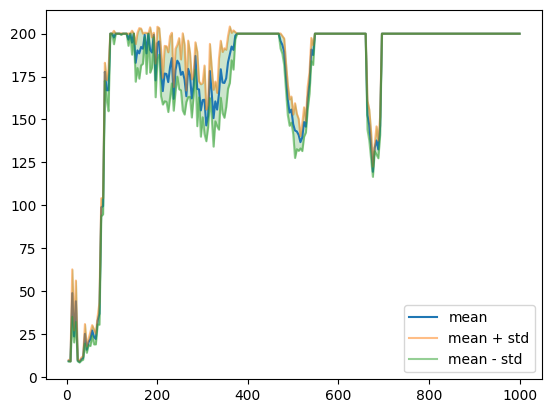

In [10]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 1000
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")

# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.

run_results = []
sac_agent = SACAgent(env)
for episode in tqdm.tqdm(range(1, EPISODES_PER_RUN + 1), total=EPISODES_PER_RUN):
    validation = episode % TRAINING_EVALUATION_RATIO == 0
    for repeat in range(TRAINING_EVALUATION_RATIO if validation else 1):
        state = env.reset()
        episode_return = 0
        for step in range(STEPS_PER_EPISODE):
            action = sac_agent.get_next_action(state, validation)
            next_state, reward, done, _ = env.step(action)
            if not validation:
                sac_agent.train_on_transition(state, action, reward, next_state, done)
            else:
                episode_return += reward
            if done:
                break
            state = next_state
        if validation:
            run_results.append(episode_return)

run_results = np.array(run_results).reshape(-1, TRAINING_EVALUATION_RATIO)
mean_results = run_results.mean(axis=1)
std_results = run_results.std(axis=1)
validation_episodes = np.arange(TRAINING_EVALUATION_RATIO, EPISODES_PER_RUN + 1, TRAINING_EVALUATION_RATIO)
plt.plot(validation_episodes, mean_results, label="mean")
plt.plot(validation_episodes, mean_results + std_results, label="mean + std", alpha=0.5)
plt.plot(validation_episodes, mean_results - std_results, label="mean - std", alpha=0.5)
plt.fill_between(validation_episodes, mean_results + std_results, mean_results - std_results, alpha=0.2, color='green')
plt.legend()
plt.show()

In [11]:
replay_buffer = sac_agent.replay_buffer
pickle.dump(replay_buffer, open("sac_replay_buffer.pkl", "wb"))

In [8]:
replay_buffer = pickle.load(open("sac_replay_buffer.pkl", "rb"))

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


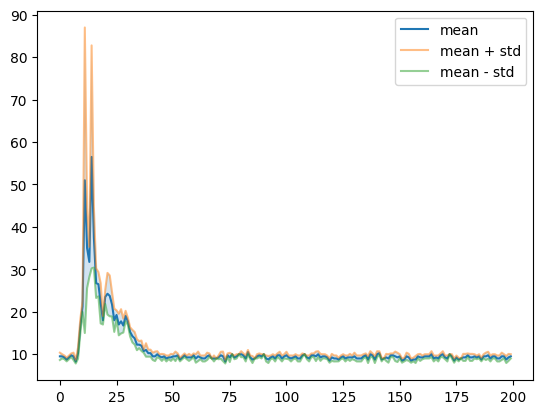

In [16]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 4

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################

run_results = []
sac_agent = SACAgent(env, replay_buffer=replay_buffer, offline=True)
for epoch in tqdm.tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS):
    for episode in range(EPISODES_PER_RUN + 1):
        validation = episode != 0
        state = env.reset()
        episode_return = 0
        for step in range(STEPS_PER_EPISODE):
            action = sac_agent.get_next_action(state, validation)
            next_state, reward, done, _ = env.step(action)
            if not validation:
                sac_agent.train_on_transition(state, action, reward, next_state, done, batch_deterministic_start=True)
            else:
                episode_return += reward
            if done:
                break
            state = next_state
        if validation:
            run_results.append(episode_return)

run_results = np.array(run_results).reshape(-1, TRAINING_EVALUATION_RATIO)
mean_results = run_results.mean(axis=1)
std_results = run_results.std(axis=1)
validation_episodes = np.arange(NUM_EPOCHS)
plt.plot(validation_episodes, mean_results, label="mean")
plt.plot(validation_episodes, mean_results + std_results, label="mean + std", alpha=0.5)
plt.plot(validation_episodes, mean_results - std_results, label="mean - std", alpha=0.5)
plt.fill_between(validation_episodes, mean_results + std_results, mean_results - std_results, alpha=0.2)
plt.legend()
plt.show()

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

100%|██████████| 200/200 [04:30<00:00,  1.35s/it]


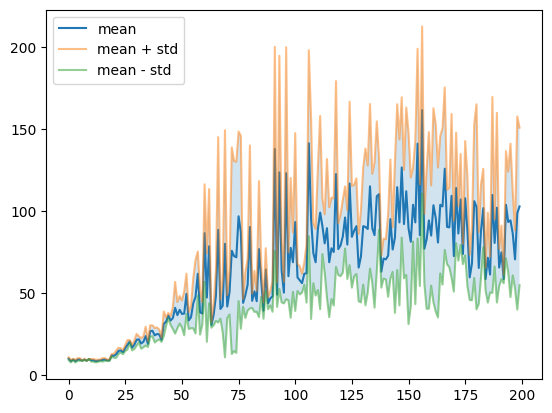

In [19]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 4

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################

run_results = []
sac_agent = SACAgent(env, replay_buffer=replay_buffer, offline=True, use_cql=True)
for epoch in tqdm.tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS):
    for episode in range(EPISODES_PER_RUN + 1):
        validation = episode != 0
        state = env.reset()
        episode_return = 0
        for step in range(STEPS_PER_EPISODE):
            action = sac_agent.get_next_action(state, validation)
            next_state, reward, done, _ = env.step(action)
            if not validation:
                sac_agent.train_on_transition(state, action, reward, next_state, done, batch_deterministic_start=True)
            else:
                episode_return += reward
            if done:
                break
            state = next_state
        if validation:
            run_results.append(episode_return)

run_results = np.array(run_results).reshape(-1, TRAINING_EVALUATION_RATIO)
mean_results = run_results.mean(axis=1)
std_results = run_results.std(axis=1)
validation_episodes = np.arange(NUM_EPOCHS)
plt.plot(validation_episodes, mean_results, label="mean")
plt.plot(validation_episodes, mean_results + std_results, label="mean + std", alpha=0.5)
plt.plot(validation_episodes, mean_results - std_results, label="mean - std", alpha=0.5)
plt.fill_between(validation_episodes, mean_results + std_results, mean_results - std_results, alpha=0.2)
plt.legend()
plt.show()

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?
* In online setting, we use the samples suggested by the model itself, so the model can learn from its own mistakes and improve itself. But in offline setting, we use a fixed dataset of samples, so the model can not learn from its own mistakes and it is limited to the dataset. And without using the conservative loss, model overestimates the Q-values of actions that are not present in the dataset, and it leads to visiting not so profitable states based on the current inaccurate estimates.

❓ Which one is better: offline SAC or conservative SAC?
* As it was expected, conservative SAC is better than offline SAC. Because it mitigates the problem mentioned in last part.

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?
* It is the $\lambda$ in the CQL loss. It is the tradeoff between the two terms in the CQL loss. If it is too small, the model will not be conservative enough, and if it is too large, the model will be too conservative and it will not learn well.